In [1]:
import zarr
from pathlib import Path
import numpy as np

BASE_PATH = Path("/scratch/")

mask_path = BASE_PATH.joinpath("693196-VS_73_sasha_smoothed.zarr")
img_path = BASE_PATH.joinpath("scaled_693196.zarr")

mask = zarr.load(mask_path).astype(np.uint8)
img = zarr.load(img_path)

print(img.shape, mask.shape, img.dtype, mask.dtype)

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

index = 200
plt.figure(figsize=(10,10))
plt.imshow(img[index, ...], cmap="gray")
plt.imshow(mask[index, ...], alpha=0.5, cmap="jet")
plt.show()

In [4]:
from scipy.ndimage import distance_transform_edt

def compute_dt_per_slice(mask):
    distance_transform = mask.copy().astype(np.float32)

    for i, curr_msk in enumerate(mask):
        if np.count_nonzero(curr_msk):
            distance_transform[i] = distance_transform_edt(curr_msk).astype(np.float32)

    return distance_transform

In [5]:
%%time
slice_distance_transform = compute_dt_per_slice(mask)

CPU times: user 34.4 s, sys: 4.17 s, total: 38.5 s
Wall time: 37.8 s


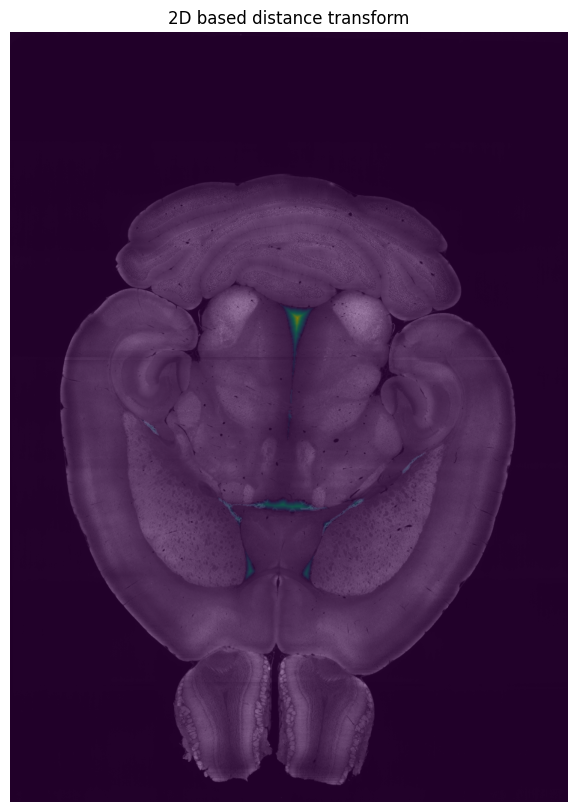

In [6]:
index = 200

plt.figure(figsize=(10, 10))

plt.imshow(img[index, ...], cmap='gray')
plt.imshow(slice_distance_transform[index, ...], alpha=0.5)
plt.title("2D based distance transform")
plt.axis('off')

plt.show()

In [12]:
from skimage.measure import regionprops, label
import heapq
from scipy.spatial.distance import cdist

def get_points_in_distance(points, d):
    """
    Sample points from the given set such that each selected point is at least distance `d` away
    from all previously selected points.

    Parameters:
    - points: A NumPy array of shape (n, m), where n is the number of points and m is the dimensionality.
    - d: Minimum distance between selected points.

    Returns:
    - A NumPy array of the selected points.
    """
    # Convert points to a NumPy array if not already
    points = np.array(points)

    # List to store the selected points
    selected_points = [points[0]]

    # Iterate over all points
    for idx, point in enumerate(points[1:]):
        # If no points have been selected yet, select the first one
        if not selected_points:
            selected_points.append(point)
        else:
            # Compute pairwise distances between the new point and the already selected points
            distances = cdist([point], selected_points)

            # If the new point is at least distance `d` away from all selected points, select it
            if np.all(distances >= d):
                selected_points.append(point)

    return np.array(selected_points)

def sort_points_by_heatmap(heatmap, points):
    """
    Sort points based on the values in the heatmap.

    Parameters:
    - heatmap: A 2D NumPy array representing the heatmap.
    - points: A NumPy array of shape (n, 2), where each row is a point with (row_index, column_index).

    Returns:
    - A sorted NumPy array of points based on their values in the heatmap.
    """
    # print(heatmap.shape, points)
    # Extract heatmap values for each point
    heatmap_values = heatmap[points[:, 0], points[:, 1]]

    # Sort points based on the heatmap values
    sorted_indices = np.argsort(heatmap_values)[::-1]
    sorted_points = points[sorted_indices]

    return sorted_points, heatmap_values[sorted_indices]

def get_sparsed_points(mask, distance_transform, n_points=5, min_point_distance=10.0):
    points = []

    for mask_index, slice_mask in enumerate(mask):
        counted_non_zero = np.count_nonzero(slice_mask)
        if counted_non_zero > 50:
            labeled_slice_mask, num_regions = label(slice_mask, return_num=True)
            
            for region_label in range(1, num_regions + 1):
                region_mask = labeled_slice_mask == region_label
                
                region_coords = np.column_stack(np.where(region_mask))

                region_coords, distance_transform_sorted = sort_points_by_heatmap(
                    distance_transform[mask_index], 
                    region_coords
                )
                
                picked_points = get_points_in_distance(region_coords, d=min_point_distance)

                picked_points = np.insert(picked_points, 0, mask_index, axis=1)
                points.append(picked_points[:n_points].copy())

    points_filtered = np.unique(np.concatenate(points, axis=0), axis=0)
    return points_filtered


In [13]:
%%time
new_points = get_sparsed_points(mask=mask, distance_transform=slice_distance_transform.copy(), n_points=3, min_point_distance=30)

CPU times: user 52.9 s, sys: 436 ms, total: 53.4 s
Wall time: 53.3 s


In [14]:
print(new_points.shape, new_points[0])

(4574, 3) [ 68 583 483]


In [15]:
new_points[1000:1010]

array([[192, 859, 393],
       [192, 864, 507],
       [192, 889, 403],
       [192, 893, 493],
       [193, 468, 479],
       [193, 500, 476],
       [193, 530, 474],
       [193, 608, 469],
       [193, 648, 465],
       [193, 665, 241]])

In [31]:
from skimage.measure import regionprops, label

def get_bounding_boxes(roi_mask):
    bounding_boxes = []
    for mask_index, slice_mask in enumerate(roi_mask):
        labeled_slice_mask, num_regions = label(slice_mask, return_num=True)
        slice_region_props = np.array([r.bbox for r in regionprops(labeled_slice_mask) if r.area > 25])

        if slice_region_props.shape[0]:
            # print(slice_region_props.shape, regionprops(labeled_slice_mask))
            slice_region_props = np.insert(slice_region_props, 0, mask_index, axis=1)
            bounding_boxes.append(slice_region_props)
        
    return np.concatenate(bounding_boxes, axis=0)

bboxs = get_bounding_boxes(roi_mask=mask.copy())

In [32]:
print(bboxs.shape, bboxs[10], bboxs[50])

(2022, 5) [ 68 579 480 590 487] [107 579 455 635 501]


In [16]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Function to plot a specific slice
def plot_slice(volume, mask, pts, slice_idx, cmap='gray'):
    plt.figure(figsize=(10, 10))
    
    slice_ = volume[slice_idx, :, :]
    slice_msk = mask[slice_idx, :, :]
    slice_points = pts[new_points[:, 0] == slice_idx]
    slice_points = slice_points[:, 1:]
    
    
    plt.imshow(slice_, cmap=cmap, vmin=0, vmax=5)
    plt.imshow(slice_msk, alpha=0.5)
    plt.scatter(slice_points[:, 1], slice_points[:, 0], c='red', s=5)
    
    plt.title(f'Slice {slice_idx} along axis {0}')
    plt.axis('off')
    plt.show()

# Interactive function for controlling slice selection
def interactive_plot(volume, mask, pts, axis=0, cmap='gray'):
    n_slices = volume.shape[axis]
    
    # Slider for selecting slices
    slice_slider = widgets.IntSlider(min=0, max=n_slices-1, step=1, value=0, description='Slice')
    
    # Update function for slider
    def update(slice_idx):
        plot_slice(volume, mask, pts, slice_idx, cmap)

    # Interactive display with slider
    interact(update, slice_idx=slice_slider)

interactive_plot(img, mask, new_points)

interactive(children=(IntSlider(value=0, description='Slice', max=457), Output()), _dom_classes=('widget-inter…

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.patches as patches

# Function to plot a specific slice
def plot_slice_box(volume, mask, bboxs, slice_idx, cmap='gray'):
    plt.figure(figsize=(10, 10))
    
    slice_ = volume[slice_idx, :, :]
    slice_msk = mask[slice_idx, :, :]
    slice_bbox = bboxs[bboxs[:, 0] == slice_idx]
    slice_bbox = slice_bbox[:, 1:]
    
    plt.imshow(slice_, cmap=cmap, vmin=0, vmax=5)
    plt.imshow(slice_msk, alpha=0.5)
    # plt.scatter(slice_points[:, 1], slice_points[:, 0], c='red', s=5)

    for bb in slice_bbox:
        minr, minc, maxr, maxc = bb
        plt.plot([minc, maxc, maxc, minc, minc], [minr, minr, maxr, maxr, minr], color='red')
    
    plt.title(f'Slice {slice_idx} along axis {0}')
    plt.axis('off')
    plt.show()

# Interactive function for controlling slice selection
def interactive_plot_bbox(volume, mask, bboxs, axis=0, cmap='gray'):
    n_slices = volume.shape[axis]
    
    # Slider for selecting slices
    slice_slider = widgets.IntSlider(min=0, max=n_slices-1, step=1, value=0, description='Slice')
    
    # Update function for slider
    def update(slice_idx):
        plot_slice_box(volume, mask, bboxs, slice_idx, cmap)

    # Interactive display with slider
    interact(update, slice_idx=slice_slider)

interactive_plot_bbox(img, mask, bboxs)

interactive(children=(IntSlider(value=0, description='Slice', max=457), Output()), _dom_classes=('widget-inter…

In [18]:
np.save('/results/sam2_points_693196.npy', new_points)

In [44]:
np.save('/results/sam2_bboxs_693196.npy', bboxs)